# Incrementally Calculate Sums and Bootstrap Instances

Configured for remote Jupyter access on Graham   
Continues on from Incremental Means

***

In [1]:
import glob
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

%matplotlib inline

In [2]:
mesh = xr.open_dataset('~/MEOPAR/grid/mesh_mask201702.nc')
tmask = 1- mesh.tmask[0, 0]
depths = np.flip(np.array(mesh.gdept_1d[0]))
print (depths)

[441.46610968 414.53408835 387.60320347 360.6745318  333.75016973
 306.83419736 279.93454976 253.06663733 226.26030574 199.57304923
 173.11448217 147.08945807 121.8665184   98.06295924  76.58558445
  58.48433368  44.51772486  34.68575798  28.22991514  24.10025665
  21.38997868  19.48178514  18.00713456  16.76117342  15.63428737
  14.56898216  13.53541212  12.51816684  11.50931127  10.5047653
   9.50243254   8.50123623   7.50062342   6.50031022   5.50015083
   4.50007042   3.50003055   2.5000115    1.50000314   0.50000027]


In [23]:
directory = ('/scratch/dlatorne/MIDOSS/runs/monte-carlo/1-200_near-BP_spill-hr_2021-12-09T134911/')
testfile_a = xr.open_dataset(directory
                             + 'results/1-200_near-BP_spill-hr-118/Lagrangian_bunker-118_1-200_near-BP_spill-hr-118.nc')

In [4]:
testfile_a

<xarray.Dataset>
Dimensions:                  (grid_x: 396, grid_x_latlon: 397, grid_y: 896, grid_y_latlon: 897, grid_z: 40, time: 167)
Coordinates:
  * time                     (time) datetime64[ns] 2018-02-03T22:30:00 ... 20...
  * grid_y                   (grid_y) int16 0 1 2 3 4 5 ... 891 892 893 894 895
  * grid_x                   (grid_x) int16 0 1 2 3 4 5 ... 391 392 393 394 395
  * grid_z                   (grid_z) int16 0 1 2 3 4 5 6 ... 34 35 36 37 38 39
  * grid_y_latlon            (grid_y_latlon) float32 0.0 1.0 2.0 ... 895.0 896.0
  * grid_x_latlon            (grid_x_latlon) float32 0.0 1.0 2.0 ... 395.0 396.0
Data variables:
    OilConcentration_2D      (time, grid_y, grid_x) float64 ...
    Thickness_2D             (time, grid_y, grid_x) float64 ...
    Dissolution_3D           (time, grid_z, grid_y, grid_x) float64 ...
    OilConcentration_3D      (time, grid_z, grid_y, grid_x) float64 ...
    OilWaterColumnOilVol_3D  (time, grid_z, grid_y, grid_x) float64 ...
    Latitude                 (grid_y_latlon, grid_x_latlon) float64 ...
    Longitude                (grid_y_latlon, grid_x_latlon) float64 ...
    Beaching_Time            (grid_y, grid_x) datetime64[ns] ...
    Beaching_Volume          (grid_y, grid_x) float64 ...
    Oil_Arrival_Time         (grid_y, grid_x) datetime64[ns] ...
Attributes:
    nco_openmp_thread_number:   1
    history:                    Thu Dec  9 20:07:08 2021: ncks -4 -L4 -A /loc...
    NCO:                        4.6.6
    history_of_appended_files:  Thu Dec  9 20:07:08 2021: Appended file /loca...

In [5]:
## Aggregate

In [4]:
minoil = 5 # litres per grid cell on beach
minSurf = 3 # litres per grid cell on surface
eps = 1e-7

In [5]:
#set up bootstrap

In [6]:
mcsize = 49
rng = np.random.default_rng()

In [7]:
pois = np.ones(mcsize+1)
pois[1:] = rng.poisson(1, mcsize)
pois

array([1., 0., 1., 0., 0., 1., 2., 3., 2., 1., 1., 1., 1., 0., 1., 2., 1.,
       0., 1., 1., 2., 2., 0., 1., 1., 1., 0., 1., 0., 2., 1., 2., 0., 1.,
       0., 1., 1., 0., 1., 0., 2., 0., 0., 0., 1., 0., 2., 2., 5., 1.])

In [8]:
# initialize (in future read in previous file)

beaching_time = np.zeros((mcsize+1, 896, 396))
beachpresence = np.zeros((896, 396))
beaching_oil = np.zeros((mcsize+1, 896, 396))
oiling_time = np.zeros((mcsize+1, 896, 396))
oilpresence = np.zeros((896, 396))
surface_oil = np.zeros((mcsize+1, 896, 396))
deeppresence = np.zeros((896, 396))
deep_oil = np.zeros((mcsize+1, 896, 396))
deep_location = np.zeros((mcsize+1, 896, 396))
files_aggregate = pd.Series(data=['empty']*10000)
count = 0

coords = dict(grid_x=(["grid_x"], np.arange(396)),
             grid_y=(["grid_y"], np.arange(896)),
             filecount=(["nf"], np.arange(10000)), )

data_vars = dict(
        beaching_time=(["c", "grid_y", "grid_x"], beaching_time),
        beachpresence=(["grid_y", "grid_x"], beachpresence),
        beaching_oil=(["c", "grid_y", "grid_x"], beaching_oil),
        oiling_time=(["c", "grid_y", "grid_x"], oiling_time),
        oilpresence=(["grid_y", "grid_x"], oilpresence),
        surface_oil=(["c", "grid_y", "grid_x"], surface_oil),
        deeppresence=(["grid_y", "grid_x"], deeppresence),
        deep_oil=(["c", "grid_y", "grid_x"], deep_oil),
        deep_location=(["c", "grid_y", "grid_x"], deep_oil),
        files_aggregate=(["nf"], files_aggregate),
        nofiles = ([], 0)   )

oils = xr.Dataset(data_vars=data_vars, coords=coords, attrs=dict(description="All types of oil"))
bunker = xr.Dataset(data_vars=data_vars, coords=coords, attrs=dict(description="Bunker Spills"))

In [52]:
def readfile_aggregate(filename, specific, oils):
    with xr.open_dataset(filename) as data:
        specific['nofiles'] = specific.nofiles + 1
        oils['nofiles'] = oils.nofiles + 1
        pois[1:] = rng.poisson(1, mcsize)
        
        beached = data.Beaching_Volume > minoil/1000.
        
        beachtime = (np.array(data.Beaching_Time - data.Beaching_Time.min())
              ) /  np.timedelta64(1, 's') /3600./24. * beached
        beach_oil = np.log(data.Beaching_Volume + eps) * beached
        
        specific['beachpresence'][:] = specific.beachpresence[:] + beached[:, :]
        oils['beachpresence'] = oils.beachpresence + beached
        specific['beaching_time'] = specific.beaching_time + (np.broadcast_to(beachtime, (mcsize+1, 896, 396)) 
                                                 * np.broadcast_to(pois, (396, 896, mcsize+1)).transpose())
        oils['beaching_time'] = oils.beaching_time + (np.broadcast_to(beachtime, (mcsize+1, 896, 396)) 
                                                 * np.broadcast_to(pois, (396, 896, mcsize+1)).transpose()) 
        specific['beaching_oil'] = specific.beaching_oil + (np.broadcast_to(beach_oil, (mcsize+1, 896, 396)) 
                                                 * np.broadcast_to(pois, (396, 896, mcsize+1)).transpose()) 
        oils['beaching_oil'] = oils.beaching_oil + (np.broadcast_to(beach_oil, (mcsize+1, 896, 396)) 
                                                 * np.broadcast_to(pois, (396, 896, mcsize+1)).transpose()) 
        
        oiled = data.OilWaterColumnOilVol_3D[:, 39].max(axis=0) > minSurf/1000.
        
        oiltime = (np.array(data.Oil_Arrival_Time - data.Oil_Arrival_Time.min())
              ) /  np.timedelta64(1, 's') /3600./24. * oiled
        oil_vol = np.log(data.OilWaterColumnOilVol_3D[:, 39].sum(axis=0) + eps) * oiled 
        
        specific['oilpresence'] = specific.oilpresence + oiled
        oils['oilpresence'] = oils.oilpresence + oiled
        specific['oiling_time'] = specific.oiling_time + (np.broadcast_to(oiltime, (mcsize+1, 896, 396)) 
                                                 * np.broadcast_to(pois, (396, 896, mcsize+1)).transpose())
        oils['oiling_time'] = oils.oiling_time + (np.broadcast_to(oiltime, (mcsize+1, 896, 396)) 
                                                 * np.broadcast_to(pois, (396, 896, mcsize+1)).transpose())
        specific['surface_oil'] = specific.surface_oil + (np.broadcast_to(oil_vol, (mcsize+1, 896, 396)) 
                                                 * np.broadcast_to(pois, (396, 896, mcsize+1)).transpose()) 
        oils['surface_oil'] = specific.surface_oil + (np.broadcast_to(oil_vol, (mcsize+1, 896, 396)) 
                                                 * np.broadcast_to(pois, (396, 896, mcsize+1)).transpose()) 
        
        specific['files_aggregate'][specific.nofiles-1] = filename
        oils['files_aggregate'][oils.nofiles-1] = filename
        print (specific.nofiles.values, oils.nofiles.values)
        
        zmax = 0
        print (depths[zmax])
        
        water_column_oil = data.OilWaterColumnOilVol_3D[:, zmax:39].sum(axis=0)        
        print (water_column_oil.shape)
        data.close()   # yes, this should happen anyway...
    oiled = water_column_oil.max(axis=0) > minSurf/1000.
    column_oil = water_column_oil.sum(axis=0) + eps
    oil_vol = np.log(column_oil) * oiled
    
    specific['deeppresence'] = specific.deeppresence + oiled
    oils['deeppresence'] = oils.deeppresence + oiled
    specific['deep_oil'] = specific.deep_oil + (np.broadcast_to(oil_vol, (mcsize+1, 896, 396)) 
                                                 * np.broadcast_to(pois, (396, 896, mcsize+1)).transpose()) 
    oils['deep_oil'] = specific.deep_oil + (np.broadcast_to(oil_vol, (mcsize+1, 896, 396)) 
                                                 * np.broadcast_to(pois, (396, 896, mcsize+1)).transpose()) 
    print(oiled.sum())
    
    location = (depths[zmax:39] * water_column_oil.transpose()).transpose().sum(axis=0) * oiled / column_oil  
    specific['deep_location'] = specific.deep_location + (np.broadcast_to(location, (mcsize+1, 896, 396)) 
                                                 * np.broadcast_to(pois, (396, 896, mcsize+1)).transpose()) 
    oils['deep_location'] = specific.deep_location + (np.broadcast_to(location, (mcsize+1, 896, 396)) 
                                                 * np.broadcast_to(pois, (396, 896, mcsize+1)).transpose())
        
        
        
    return specific, oils

In [53]:
for filename in glob.glob(directory+'results/*/Lagrangian*bunker*.nc')[4:5]:
    print ('in')
    bunker, oils = readfile_aggregate(filename, bunker, oils)

in
5 5
441.4661096800038
(39, 896, 396)
<xarray.DataArray 'OilWaterColumnOilVol_3D' ()>
array(0)


In [50]:
bunker.files_aggregate

<xarray.DataArray 'files_aggregate' (nf: 10000)>
array(['/scratch/dlatorne/MIDOSS/runs/monte-carlo/1-200_near-BP_spill-hr_2021-12-09T134911/results/1-200_near-BP_spill-hr-118/Lagrangian_bunker-118_1-200_near-BP_spill-hr-118.nc',
       '/scratch/dlatorne/MIDOSS/runs/monte-carlo/1-200_near-BP_spill-hr_2021-12-09T134911/results/1-200_near-BP_spill-hr-181/Lagrangian_bunker-181_1-200_near-BP_spill-hr-181.nc',
       '/scratch/dlatorne/MIDOSS/runs/monte-carlo/1-200_near-BP_spill-hr_2021-12-09T134911/results/1-200_near-BP_spill-hr-91/Lagrangian_bunker-91_1-200_near-BP_spill-hr-91.nc',
       ..., 'empty', 'empty', 'empty'], dtype=object)
Coordinates:
    filecount  (nf) int64 0 1 2 3 4 5 6 7 ... 9993 9994 9995 9996 9997 9998 9999
    grid_z     int16 39
Dimensions without coordinates: nf

In [ ]:
for filename in glob.glob(directory+'results/*/Lagrangian*bunker*.nc')[0:1]:
    print ('in')
    with xr.open_dataset(filename) as data:
        water_column_oil = data.OilWaterColumnOilVol_3D[:, 30:39].sum(axis=0)
        column_oil = water_column_oil.sum(axis=0)
        oiled = column_oil > minSurf/1000.
        oil_vol = np.log(column_oil + eps) * oiled
        location = (depths[30:39] * water_column_oil.transpose()).transpose().sum(axis=0) * oiled / (column_oil + eps)
        
        print (oil_vol.max(), location.shape, location.max())
    
#    bunker, oils = readfile_aggregate(filename, bunker, oils)
#print(bunker.files_aggregate[:5])

in
<xarray.DataArray 'OilWaterColumnOilVol_3D' ()>
array(0.3377572) (896, 396) <xarray.DataArray 'OilWaterColumnOilVol_3D' ()>
array(8.50101251)
in


In [1]:
james

NameError: name 'james' is not defined

In [19]:
np.log(data.OilWaterColumnOilVol_3D[:, 39].sum(axis=0) + eps)

<xarray.DataArray 'OilWaterColumnOilVol_3D' (grid_y: 896, grid_x: 396)>
array([[-16.11809565, -16.11809565, -16.11809565, ..., -16.11809565,
        -16.11809565, -16.11809565],
       [-16.11809565, -16.11809565, -16.11809565, ..., -16.11809565,
        -16.11809565, -16.11809565],
       [-16.11809565, -16.11809565, -16.11809565, ..., -16.11809565,
        -16.11809565, -16.11809565],
       ...,
       [-16.11809565, -16.11809565, -16.11809565, ..., -16.11809565,
        -16.11809565, -16.11809565],
       [-16.11809565, -16.11809565, -16.11809565, ..., -16.11809565,
        -16.11809565, -16.11809565],
       [-16.11809565, -16.11809565, -16.11809565, ..., -16.11809565,
        -16.11809565, -16.11809565]])
Coordinates:
  * grid_y   (grid_y) int16 0 1 2 3 4 5 6 7 ... 888 889 890 891 892 893 894 895
  * grid_x   (grid_x) int16 0 1 2 3 4 5 6 7 ... 388 389 390 391 392 393 394 395
    grid_z   int16 39

# Beaching Time

In [38]:
# Good if good to half a day or 15% of beaching time
absol = 0.5
perol = 0.15
print (0.15*7)

1.05


In [39]:
beachpresence.max()

<xarray.DataArray 'Beaching_Volume' ()>
array(6.)

In [40]:
beachpresence[315, 310]

<xarray.DataArray 'Beaching_Volume' ()>
array(6.)
Coordinates:
    grid_y   int16 315
    grid_x   int16 310

In [41]:
ma_beaching_time = np.ma.masked_array(beaching_time[0]/(beachpresence + eps), beachpresence == 0)
den = np.minimum(np.array(beachpresence) + eps, mcsize)
beached_ste = np.std(beaching_time, axis=0, ddof=1) / np.sqrt(den)
beached = np.ma.masked_array(beaching_time[0]/(beachpresence + eps), (beachpresence <= 1) | (
    (beached_ste/(beachpresence+eps) > absol) & (beached_ste > perol*beaching_time[0]))) 

In [42]:
ma_beaching_time.count()

1299

In [43]:
beached.count()

67

In [44]:
ma_beached_ste = np.ma.masked_array(beached_ste, beached_ste == 0)

In [13]:
imin, imax = 225, 225+(380-250)*2/500*440
jmin, jmax = 250, 380

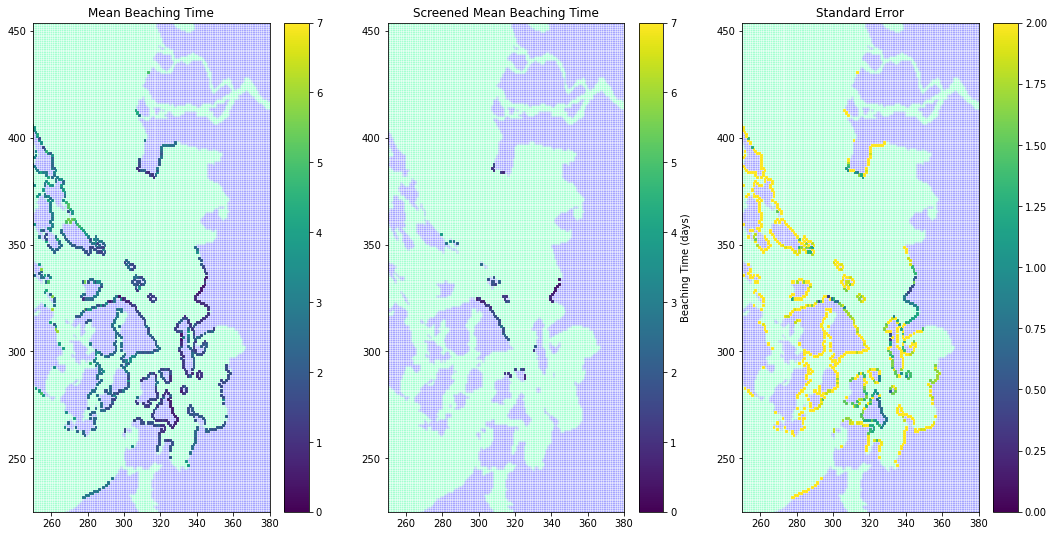

In [46]:
fig, axs = plt.subplots(1, 3, figsize=(18, 9))

for ax in axs:
    ax.pcolormesh(tmask[1:, 1:], cmap='winter_r', alpha=0.1)
    ax.set_ylim(imin, imax)
    ax.set_xlim(jmin, jmax)

C = axs[0].pcolormesh(
     ma_beaching_time,
    zorder=2, vmin=0, vmax=7
)
cb = fig.colorbar(C, ax=axs[0]);    
axs[0].set_title('Mean Beaching Time')
    
C = axs[1].pcolormesh(
     beached,
    zorder=2, vmin=0, vmax=7
)
cb = fig.colorbar(C, ax=axs[1]);
cb.set_label('Beaching Time (days)')
axs[1].set_title('Screened Mean Beaching Time')

C = axs[2].pcolormesh(
     ma_beached_ste,
    zorder=2, vmin=0, vmax=2
)
cb = fig.colorbar(C, ax=axs[2]);
axs[2].set_title('Standard Error');


# Beaching Presence

In [47]:
ma_beaching_pres = np.ma.masked_array(beachpresence, beachpresence == 0)

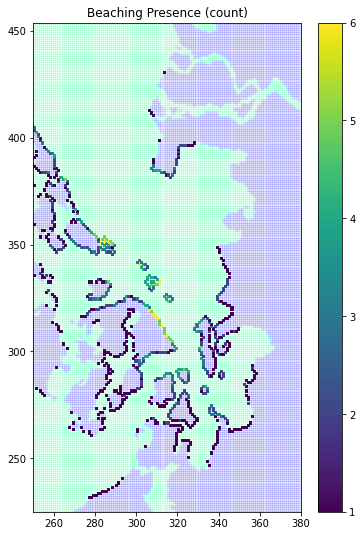

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(6, 9))

ax.pcolormesh(tmask[1:, 1:], cmap='winter_r', alpha=0.1)
ax.set_ylim(imin, imax)
ax.set_xlim(jmin, jmax)


C = ax.pcolormesh(
     ma_beaching_pres,
    zorder=2, #vmin=0, vmax=7
)
cb = fig.colorbar(C, ax=ax);    
ax.set_title('Beaching Presence (count)');    


In [49]:
## Beached Oil

(array([ 1.,  6.,  3.,  9.,  8.,  7., 10.,  2.,  1.,  3.]),
 array([-25.09781608, -22.6316468 , -20.16547753, -17.69930825,
        -15.23313897, -12.7669697 , -10.30080042,  -7.83463114,
         -5.36846187,  -2.90229259,  -0.43612331]),
 <BarContainer object of 10 artists>)

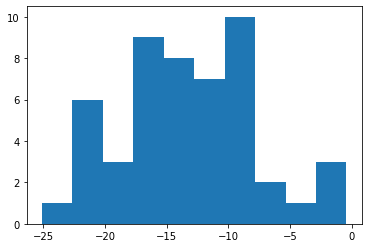

In [50]:
plt.hist(beaching_oil[:, 315, 310])

In [51]:
# Good if good to 100% of beaching volume
absol = np.exp(1)

In [52]:
ma_beach_oil = np.ma.masked_array(beaching_oil[0]/(beachpresence + eps), beachpresence == 0)
den = np.minimum(np.array(beachpresence) + eps, mcsize)
beachoil_ste = np.std(beaching_oil, axis=0, ddof=1) / np.sqrt(den)
beachedoil = np.ma.masked_array(beaching_oil[0], (beachpresence <= 1) | (
    (beachoil_ste/(beachpresence+eps) > absol) )) 

In [53]:
ma_beachoil_ste = np.ma.masked_array(beachoil_ste, beachoil_ste == 0)

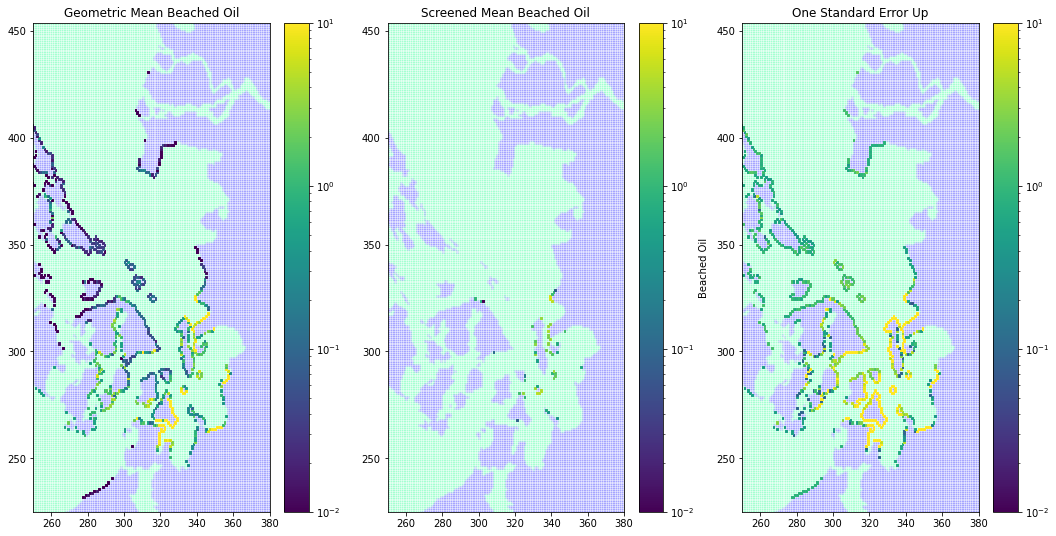

In [55]:
fig, axs = plt.subplots(1, 3, figsize=(18, 9))

for ax in axs:
    ax.pcolormesh(tmask[1:, 1:], cmap='winter_r', alpha=0.1)
    ax.set_ylim(imin, imax)
    ax.set_xlim(jmin, jmax)

C = axs[0].pcolormesh(
     np.exp(ma_beach_oil), norm=colors.LogNorm(vmin=0.01, vmax=10),
    zorder=2, 
)
cb = fig.colorbar(C, ax=axs[0]);    
axs[0].set_title('Geometric Mean Beached Oil')
    
C = axs[1].pcolormesh(
     beachedoil,
    zorder=2, norm=colors.LogNorm(vmin=0.01, vmax=10),
)
cb = fig.colorbar(C, ax=axs[1]);
cb.set_label('Beached Oil')
axs[1].set_title('Screened Mean Beached Oil')

C = axs[2].pcolormesh(
     np.exp(ma_beachoil_ste + ma_beach_oil) - np.exp(ma_beach_oil), norm=colors.LogNorm(vmin=0.01, vmax=10),
    zorder=2, 
)
cb = fig.colorbar(C, ax=axs[2]);
axs[2].set_title('One Standard Error Up');

In [56]:
## Oil Presence

In [54]:
ma_oil_pres = np.ma.masked_array(bunker.oilpresence, bunker.oilpresence == 0)
print (ma_oil_pres.shape)

(896, 396)


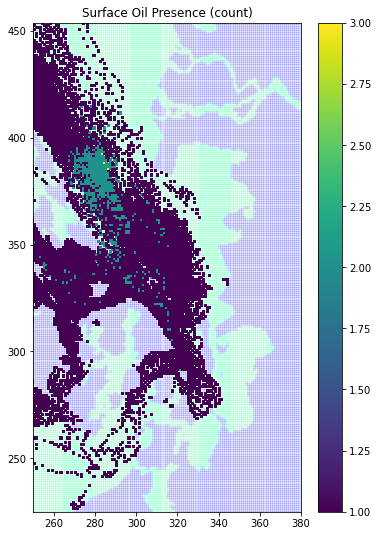

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(6, 9))

ax.pcolormesh(tmask[1:, 1:], cmap='winter_r', alpha=0.1)
ax.set_ylim(imin, imax)
ax.set_xlim(jmin, jmax)


C = ax.pcolormesh(
     ma_oil_pres,
    zorder=2, #vmin=0, vmax=7
)
cb = fig.colorbar(C, ax=ax);    
ax.set_title('Surface Oil Presence (count)');    

In [18]:
## Deep Presence

In [47]:
ma_deep_pres = np.ma.masked_array(bunker.deeppresence, bunker.deeppresence == 0)

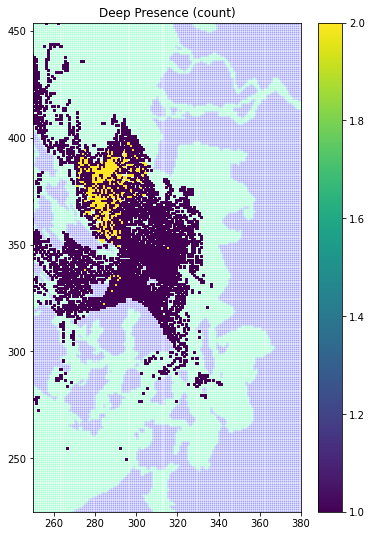

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(6, 9))

ax.pcolormesh(tmask[1:, 1:], cmap='winter_r', alpha=0.1)
ax.set_ylim(imin, imax)
ax.set_xlim(jmin, jmax)


C = ax.pcolormesh(
     ma_deep_pres,
    zorder=2, #vmin=0, vmax=7
)
cb = fig.colorbar(C, ax=ax);    
ax.set_title('Deep Presence (count)');    

In [41]:
ma_deep_location = np.ma.masked_array(bunker.deep_location[0]/(bunker.deeppresence + eps), bunker.deeppresence == 0)

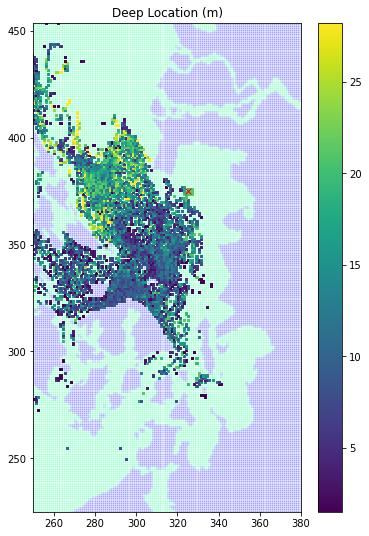

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(6, 9))

ax.pcolormesh(tmask[1:, 1:], cmap='winter_r', alpha=0.1)
ax.set_ylim(imin, imax)
ax.set_xlim(jmin, jmax)


C = ax.pcolormesh(
     ma_deep_location,
    zorder=2, #vmin=0, vmax=7
)
cb = fig.colorbar(C, ax=ax);    
ax.plot(325, 375, 'xr')
ax.set_title('Deep Location (m)');    

(50.0, 0.0)

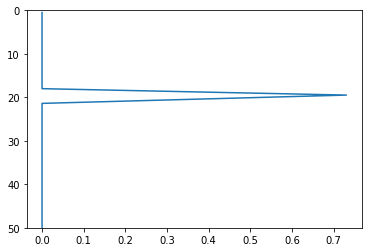

In [34]:
fig, ax = plt.subplots()
ax.plot(testfile_a.OilWaterColumnOilVol_3D[:, :, 375, 325].sum(axis=0), depths);
ax.set_ylim(50, 0);